1- Import Librarys


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings

import torch.nn as nn
import torch 
import torch.optim as optim
import torch.utils.data as data_utils
from torchsummary import summary


2- Preprocessing Dataset

In [2]:
# Prepare Features

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
mean_std_labels=['mean_idle', 'mean_m_weehl','mean_clik_left','mean_click_right', 'mean_m_mouvement','mean_keystroke','std_idle', 'std_m_weehl','std_clik_left','std_click_right', 'std_mouvement','std_keystroke']
student_id_list=[2,4,5,7,11,12,14,19,20,30,38,39, 42,44,47,49,51,52,56,59,67,70,79,80,82]
input = []
#input2 = pd.DataFrame()


names=['session','student_Id', 'exercise', 'activity', 'start_time', 'end_time', 'idle_time', 'mouse_wheel','mouse_wheel_click','mouse_click_left','mouse_click_right','mouse_mouvement','keystroke']
scaler = preprocessing.MinMaxScaler()

preprocessed_data=pd.DataFrame(columns=mean_std_labels)

for id in student_id_list:
    for session in range(1,7):
        
        
        # specifying the path to csv files
        path = "../Data/Processes/Session "+str(session)+"/"+str(id)
        
        data=pd.read_csv(path, sep = ',', names=names)
        reduced_data = data.iloc[:,6:]
        reduced_data.drop("mouse_wheel_click", axis=1, inplace=True)

        mean_values=reduced_data.mean(axis=0)
        std_values=reduced_data.std(axis=0)
        df=pd.concat([mean_values,std_values],axis=0)
        #print(df)
        values=df.values
        preprocessed_data.loc[session-1]=values.reshape(-1)

    scaled_preprocessed_data = scaler.fit_transform(preprocessed_data)
    input.append(scaled_preprocessed_data)
print(len(input))

25


In [3]:
# Prepare Target
#Binarize Target

from pandas import ExcelFile

target_data = pd.read_excel('../dataset/final_grades_transformed.xlsx', engine='openpyxl', sheet_name='Exam (Second time)')

#print(target_data)
# 1 if greater than 50, 0 otherwise
target_data['TOTAL'] = (target_data['TOTAL'] >= 50.0).astype(int)
reduced_target=target_data[['StudentID','TOTAL']]
#reduced_target.to_csv('../dataset/target1.csv', index=False, sep = ',')

#target=target_data['TOTAL']
target_id=reduced_target['StudentID'].values
reduced_target.set_index('StudentID', inplace=True)

#print(student_id_list)
#print(target_id)

for id in target_id:
    if id not in student_id_list:
        reduced_target=reduced_target.drop(id)

#print(reduced_target)

#Iterate over columns using DataFrame.iteritems()
#print(reduced_target['TOTAL'].values)

3- Split Dataset

In [4]:
X = input
Y= reduced_target['TOTAL'].values


#Training data
X_train = X[0:20]
Y_train = Y[0:20]
x_train = torch.FloatTensor(np.array(X_train))
y_train = torch.LongTensor(Y_train)

#Test data
X_test  = X[20:]
Y_test = Y[20:]
x_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(Y_test)
print(x_train.shape)
print(y_test.shape)

#Load Data
train = data_utils.TensorDataset(x_train, y_train)
test = data_utils.TensorDataset(x_test, y_test)
train_loader = data_utils.DataLoader(train, batch_size=6, shuffle=False)
test_loader = data_utils.DataLoader(test, batch_size=1, shuffle=False)


torch.Size([20, 6, 12])
torch.Size([5])


In [5]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")

using cpu device


4- Define Model Architecture

In [6]:
#from tqdm import tqdm  # For a nice progress bar!

#Model- and Hyperparameters
input_size=12
hidden_size=24
num_layers=6
num_classes=2
batch_size=8
sequence_length=6


# Recurrent neural network (many-to-one)
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

# Initialize network 
model = RNN2(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

RNN2(
  (rnn): RNN(12, 24, num_layers=6, batch_first=True)
  (fc): Linear(in_features=144, out_features=2, bias=True)
)


Train

In [16]:
torch.manual_seed(0)
num_epochs=100
learning_rate=0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_list=[]
size = len(train_loader.dataset)

model.train()

# Train Model
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(train_loader): #(tqdm(train_loader)
        # Get data to cuda if possible
        x = x.to(device=device).squeeze(1)
        y = y.to(device=device)

        # forward
        scores = model(x)
        loss = criterion(scores, y)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()
        loss_list.append(loss.item())
        
        # print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
        # if batch_idx % 20 == 0:
        #     loss, current = loss.item(), batch_idx * len(x)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Plot loss

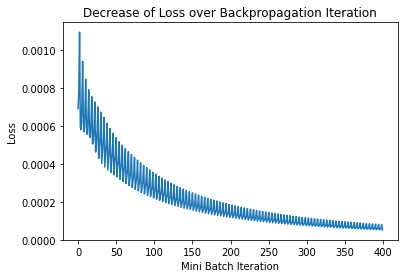

In [18]:
plt.plot(loss_list)
plt.title('Decrease of Loss over Backpropagation Iteration')
plt.xlabel('Mini Batch Iteration')
plt.ylabel('Loss')
plt.show()

In [20]:
predicted=np.array([])
print('Testing:\n========')

for i, item in enumerate(x_test):
	model.eval()
	with torch.no_grad():
		print(y_test[i])
		outp = model(item.unsqueeze(0))
		print(np.argmax(outp.detach()))

Testing:
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


Accuracy

In [19]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    # Toggle model back to train
    #model.train()
    return num_correct / num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 100.000000
Accuracy on test set: 80.00


In [20]:
summary(model,(6,12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 6, 24], [-1, 2, 24]]               0
            Linear-2                    [-1, 2]             290
Total params: 290
Trainable params: 290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


Compare Train and Test Loss

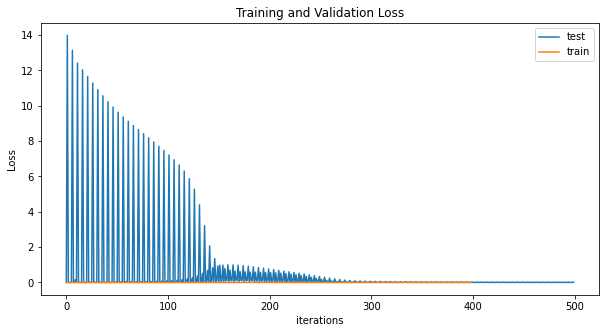

In [21]:
import matplotlib.pyplot as plt

val_losses = []
train_losses = []


# training Loss
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(train_loader): 
        # Get data to cuda if possible
        x = x.to(device=device).squeeze(1)
        y = y.to(device=device)
        
        # Set model to eval
        model.eval()

        # forward
        scores = model(x)
        loss_train = criterion(scores, y)

        # backward
        optimizer.zero_grad()
        loss_train.backward()

        # gradient descent update step/adam step
        optimizer.step()
        train_losses.append(loss_train.item())


# testing Loss
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(test_loader):
        # Get data to cuda if possible
        x = x.to(device=device).squeeze(1)
        y = y.to(device=device)
        
        # Set model to eval
        model.eval()

        # forward
        scores = model(x)
        loss_val = criterion(scores, y)

        # backward
        optimizer.zero_grad()
        loss_val.backward()

        # gradient descent update step/adam step
        optimizer.step()
        val_losses.append(loss_val.item())



plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="test")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Make Prediction

In [22]:
#Testing 
model.eval()
print('Testing:\n========')
i = 4
actual = y_test[i]
with torch.no_grad():
	
	outp = model(x_test[0].unsqueeze(0))
	predicted=np.argmax(outp.detach())

print(f'Predicted: "{predicted}", Actual: "{actual}"')


Testing:
Predicted: "1", Actual: "0"


In [65]:
y_test

tensor([1, 1, 1, 1, 0])

F1-score

In [23]:
predicted=[]
model.eval()
print('Evaluate Testing Set:\n========')
for i, item in enumerate(x_test):
	with torch.no_grad():
	#print(y_train[i])
		outp = model(item.unsqueeze(0))
	#np.append(predicted,np.argmax(outp.detach()).numpy(),axis=None)
	#print(np.argmax(outp.detach()))
		predicted.append(np.argmax(outp.detach()))

#predicted=np.asarray(predicted)

#print(predicted)
#print(y_train)

from torchmetrics.functional import f1_score
target = y_test
preds = torch.tensor(predicted,dtype=torch.long)
fa_scor=f1_score(preds, target, num_classes=2)
print(f"F1-Score =  {fa_scor}")

print(f"Predicted Class: {preds}")
print(f"Actual Calss:  {target}")

Evaluate Testing Set:
F1-Score =  1.0
Predicted Class: tensor([1, 1, 1, 1, 0])
Actual Calss:  tensor([1, 1, 1, 1, 0])


In [24]:
predicted=[]
model.eval()
print('Evaluate Testing Set:\n========')
for i, item in enumerate(x_test):
	outp = model(item.unsqueeze(0))
	predicted.append(np.argmax(outp.detach()))

from torchmetrics.functional import f1_score
target = y_test
preds = torch.tensor(predicted,dtype=torch.long)
fa_scor=f1_score(preds, target, num_classes=2)
print(f"F1-Score =  {fa_scor:.2f}")

print(f"Predicted Class: {preds}")
print(f"Actual Calss:  {target}")

Evaluate Testing Set:
F1-Score =  1.00
Predicted Class: tensor([1, 1, 1, 1, 0])
Actual Calss:  tensor([1, 1, 1, 1, 0])


In [25]:
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test(test_loader, model, criterion)

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005018 



<function matplotlib.pyplot.show(close=None, block=None)>

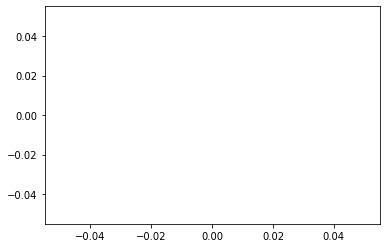

In [67]:
loss_list_new=[]

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list_new.append(loss.item())
        
        if batch % 3 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

In [74]:
 
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")    
    train(train_loader,model,criterion, optimizer)
    test(test_loader, model, criterion)

Epoch 1
-------------------------------
loss: 0.000117  [    0/   20]
loss: 0.000058  [    6/   20]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.646506 

Epoch 2
-------------------------------
loss: 0.000115  [    0/   20]
loss: 0.000056  [    6/   20]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.651040 

Epoch 3
-------------------------------
loss: 0.000112  [    0/   20]
loss: 0.000055  [    6/   20]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.655534 

Epoch 4
-------------------------------
loss: 0.000110  [    0/   20]
loss: 0.000054  [    6/   20]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.659991 

Epoch 5
-------------------------------
loss: 0.000108  [    0/   20]
loss: 0.000053  [    6/   20]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.664407 

Epoch 6
-------------------------------
loss: 0.000106  [    0/   20]
loss: 0.000052  [    6/   20]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.668787 

Epoch 7
-------------------------------
loss: 0.000104  [    0/   20]
loss: 0.000051  [ 

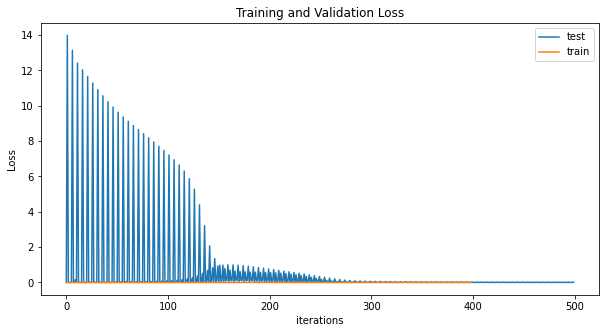

In [26]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="test") #val_losses
plt.plot(train_losses,label="train") #train_losses
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
#print(summary(RNN2,input_size,batch_size,device,))
summary(model,(6,12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 6, 24], [-1, 2, 24]]               0
            Linear-2                    [-1, 2]             290
Total params: 290
Trainable params: 290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


Save Module

In [69]:
m = RNN2(input_size, hidden_size, num_layers, num_classes)
m.state_dict()


OrderedDict([('rnn.weight_ih_l0',
              tensor([[-0.1571,  0.1370,  0.1451, -0.0232, -0.1181,  0.1578,  0.1305,  0.0152,
                       -0.0964,  0.1876,  0.0835, -0.1550],
                      [ 0.1954,  0.1550, -0.0744,  0.1147, -0.1160, -0.0320,  0.1733,  0.0084,
                       -0.1444, -0.0682, -0.0554, -0.0394],
                      [ 0.0195,  0.1888,  0.0109, -0.1260,  0.0105,  0.0979,  0.1013, -0.1866,
                       -0.0365, -0.1517, -0.0871,  0.0735],
                      [-0.1450,  0.0759,  0.1733,  0.0134, -0.1360, -0.0731,  0.0446, -0.1556,
                        0.1014, -0.1853, -0.1962, -0.1983],
                      [-0.0414,  0.1373, -0.1932,  0.1697, -0.0817,  0.0598,  0.0093, -0.1841,
                        0.1693,  0.1099,  0.2029,  0.1031],
                      [-0.1347,  0.1704,  0.0110,  0.0968, -0.1637, -0.0587, -0.2004, -0.0795,
                        0.0440, -0.1603,  0.0651,  0.1096],
                      [ 0.0284, -0.1

In [70]:
torch.save(m.state_dict(), '../model/RNNPredictor.pt')

In [71]:
# load model
m_state_dict = torch.load('../model/RNNPredictor.pt')
new_m = RNN2(input_size, hidden_size, num_layers, num_classes)
new_m.load_state_dict(m_state_dict)

<All keys matched successfully>

In [27]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,}, "../model/RNN_train_with_state100.pt")